Please enter your team number and members here:

Team NR: 50

Team Members: 

In [1]:
PROJECT_ROOT = './' 


import sys
from os.path import join as ospj
sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

In this part of assignment 4 we try to
1. implement the forward pass of ViT
2. visualize the attention weights for the final CLS Token.


For evaluation and visualization, we use an 8-class subset (out of 1000) of Imagenet-V2. We use a subset, simply just so that you can run the cells faster.
The model is pre-trained and you just need to download the weights.

Furthermore, most of the relevant modules for ViT, such as the positional embedding, the linear projection, MLP Block, and Multi-head attention are all already implemented. What you mainly have to do is to plug these modules together based on what you've seen in lecture 7 (the ViT slides).

You probably shouldn't need GPU for running this assignment, as there is no training and the dataset is very small and every cell. But of course feel free to change the notebook so that it works on GPU if desired.

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm 

from models.vit.model import VisionTransformer
from src.utils.imagenet_names import name_map

## Downloading pre-trained weights

Please Download the weights from `https://download.pytorch.org/models/vit_b_16-c867db91.pth` and place it under `saved/models/vit/vit.pth`. The file size is 330M.


or you can just download and place it by running the cell below (tested on Linux).

In [ ]:
!wget "https://download.pytorch.org/models/vit_b_16-c867db91.pth"

# Change the relative paths below to absolute paths if running on Colab
!mkdir ..\..\saved\models\vit

!move vit_b_16-c867db91.pth ..\..\saved\models\vit\vit.pth

        1 file(s) moved.


In [18]:
import urllib.request
import os
import shutil

# Download the model
url = "https://download.pytorch.org/models/vit_b_16-c867db91.pth"
filename = "vit_b_16-c867db91.pth"
urllib.request.urlretrieve(url, filename)

# Create the directory structure
target_dir = os.path.join("..","assignment4", "saved", "models", "vit")
os.makedirs(target_dir, exist_ok=True)

# Move the file to the target directory
shutil.move(filename, os.path.join(target_dir, "vit.pth"))

'..\\assignment4\\saved\\models\\vit\\vit.pth'

## Q1: ViT Inference (15 points)


For this part you need to complete the missing parts of the ViT model. 

<img src="./data/exercise-4/ViT.png" width=1400 />

There are overall 7 `TODO Q1`s to be implemented for this question. 

You can of course define new attributes in the classes if you find it necessary. However, you cannot define new modules *with parameters* or change the name modules with parameters.
Otherwise, the `load_state_dict` will fail to match the weight values in the file with the code. Also changing the configs such as number of layers or dimensions would cause the same mismatch in loading weights.



In [3]:
weights = torch.load(ospj(PROJECT_ROOT,'saved/models/vit/vit.pth'))

model = VisionTransformer(
            image_size=224, # Input image size (width and height)
            patch_size=16,  # Image broken into (16 x 16) non-overlaping batches
            num_layers=12,  # Number of blocks in the Encoder
            num_heads=12,   # Number of heads in each Multi-"head" attention
            hidden_dim=768, # Token size (length of a single token)
            mlp_dim=3072,   # Hidden layer size of each MLP layer
        )

model.load_state_dict(weights, strict=True)

<All keys matched successfully>

Create the Dataset

We're using only 8 classes of Imagenet-V2 for this assignment. Feel free to checkout the entire dataset (https://github.com/modestyachts/ImageNetV2).

In [5]:
# Since we're just using a subset of classes, the labels that ImageFolder generates (starting from 0 to 7) 
# should be converted back to correct (0 to 999) numbers.
def label_convert(idx):
    class_subset = sorted([19, 330, 466, 558, 672, 716, 755, 986,])
    return class_subset[idx] # e.g. 0 -> 19, 2 -> 466

IMN_MEAN, IMN_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=IMN_MEAN, std=IMN_STD) 
    ]
)

dataset = datasets.ImageFolder(
        root=ospj(PROJECT_ROOT, 'data/exercise-4/IMN-Subset'),
        transform=t, 
        target_transform=label_convert
    )
print(f"Test set is created with {len(dataset)} samples")

Test set is created with 80 samples


In [8]:
loader = DataLoader(
                dataset=dataset,
                drop_last=False,
                shuffle=False, 
                batch_size=16, # Change the batch size if the model doesn't fit into memory.
                num_workers=0,
        )

In [9]:
num_correct = 0
total_cnt = 0
model.eval()

with torch.no_grad():
    for batch_idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
        out, attention_weights = model(images)
        pred = out.argmax(dim=1)

        num_correct += (pred == targets).sum()
        total_cnt += len(images)

top1_acc = 100*num_correct/total_cnt

print(f"Top-1 Acc on Test set is {100 * num_correct/total_cnt}")
# Should be very close to 83.75

100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

Top-1 Acc on Test set is 83.75


# Visualize the Attention (5 Points)

In [15]:
# This is just used to reverse the normalization done in the Dataset transforms.
def unnormalize(img_tensor):
    assert img_tensor.ndim == 3 and img_tensor.shape[0] == 3
    img_tensor = img_tensor * torch.Tensor(IMN_STD)[:, None, None]
    img_tensor = img_tensor + torch.Tensor(IMN_MEAN)[:, None, None]

    return img_tensor

Pick an image!

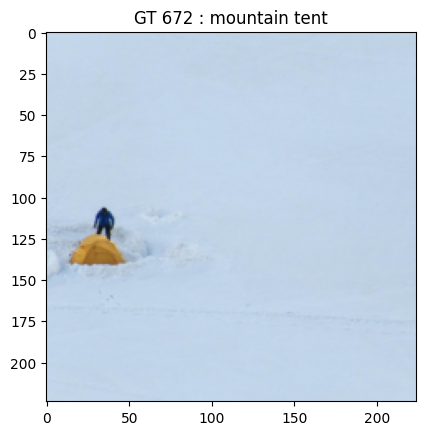

In [19]:
x, label = dataset[42]
plt.title(f"GT {label} : {name_map[label]}")
plt.imshow(unnormalize(x).moveaxis(0, -1))

Predicted class 802 : snowmobile


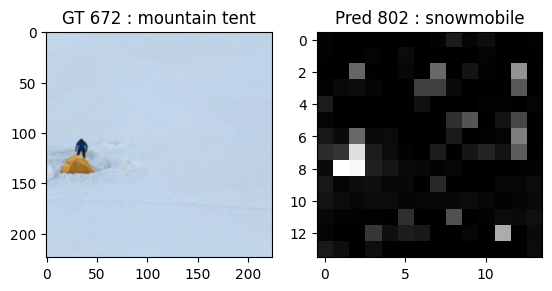

In [20]:
with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(unnormalize(x).moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

Predicted class 587 : hammer


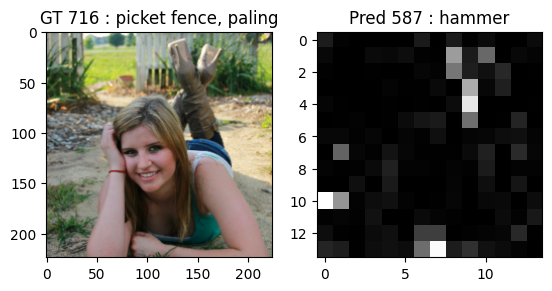

In [22]:
x, label = dataset[54]

with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(unnormalize(x).moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

Predicted class 330 : wood rabbit, cottontail, cottontail rabbit


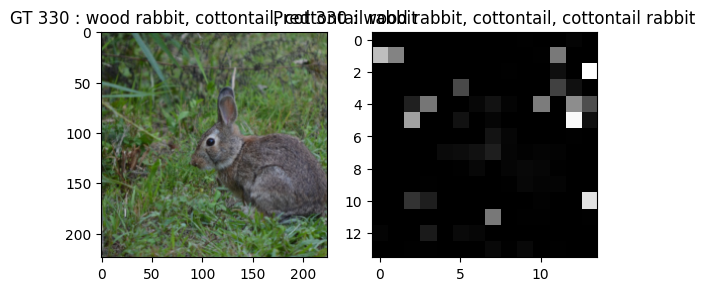

In [24]:
x, label = dataset[11]

with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(unnormalize(x).moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

Predicted class 466 : bullet train, bullet


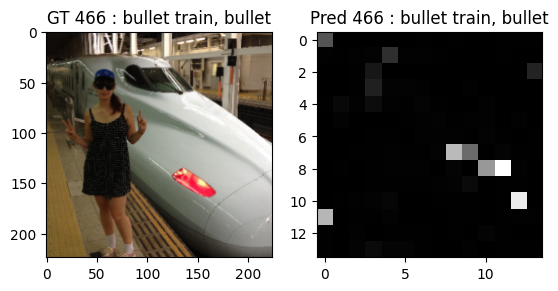

In [25]:
x, label = dataset[24]

with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(unnormalize(x).moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

## Please briefly answer the following based on your intuition. (5 points)

1. Why does the attention map have lower resolution?

Answer:

The attention map has lower resolution because the input image which has 224 by 224 pixels is divided into non-overlapping patches of size 16x16, resulting in a grid of 14 by 14 patches. Each patch corresponds to a single token in the ViT, and the CLS token’s attention weights are computed with respect to these patches. As a result, the attention map is defined over this 14 by 14 grid, which is significantly lower resolution than the original 224 by 224 image. This patch-based although redcues computational complexity, it causes losing spatial details in the attention map.

2. Browse other samples of the dataset (simply change the idx above or add extra cells below). Is the attention map of final CLS token always localized on the object? Briefly explain your intuition behind what you see.

Answer:

No, it is not always localized on the object. As it is evident from the visualizations above, the CLS token's attention in some cases is focused on the object (like in the case of image number 42), but in many other cases it has been spread across background regions (case of number 11) or across multiple areas. This happens because the CLS token aggregates global information across all patches via self-attention, and its attention weights reflect which patches contribute most to the classification decision. For complex images or objects with indistinct boundaries, the attention may highlight contextual or background features that the model deems relevant, rather than strictly the object itself.

3. As mentioned above, we're only visualizing the attention weights of the CLS token at the last layer.
   
   Can you think of any problems regarding this? 

   Answer:

   Visualizing only the last layer's CLS token may potentially lead to loss of intermediate information. This final token attention reflects the final aggregated representation, but earlier layers may capture more localized or low-level features. Moreover, the CLS token's attention may not fully explain the model's decision, as it only shows which patches it attends to, not why or how those patches contribute to the class prediction.The attention map may spread across irrelevant areas if the model relies on contextual cues, making it hard to pinpoint the object of interest.

   Can you come up with some other way of looking into a decision made by a transformer model?

   Answer:

   One way would be to visualize attention across all layers. In this way we compute and average attention weights for the CLS token across all layers to capture both low-level and high-level feature contributions. This can give us information about how attention evolves through the network. Or another method would be visualizing attention maps for patch tokens and not just the CLS token to see inter-patch relationships, which can highlight regions of interest beyond the CLS token’s perspective.
